In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
    compress_repeated_epochs
)
from ripple_heterogeneity.readout import downstream_information
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats
from statannotations.Annotator import Annotator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
105,Z:\Data\FujisawaS\EE\EE0705fm
106,Z:\Data\FujisawaS\EE\EE0706fm
107,Z:\Data\FujisawaS\EE\EE0708fm
108,Z:\Data\HMC1\day12


## Main analysis

In [3]:
basepath = r"Z:\Data\FujisawaS\EE\EE0705fm"
results = downstream_information.run(basepath,n_shuffles=10,parallel_shuffle=False)

$I(X,Y)=-\sum_{x_i,y_i} p(x_i,y_i)log_2 \frac{p(x_i,y_i)}{p(x_i)p(y_i)}$


In [5]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\downstream_info_v3"
    )

batch_analysis.run(
    sessions,
    save_path,
    downstream_information.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
results = downstream_information.load_results(save_path)

100%|██████████| 110/110 [04:41<00:00,  2.56s/it]


In [345]:
results

,mutual_info,pval,label,reference_id,target_id,reference,target,reference_uid,target_uid,conditional_entropy,environment,epoch,basepath
0,0.001990,1.0,deep_mec,0,16,CA1,MEC,59,87,NaN,sleep,pre,Z:\Data\AYAold\AYA7\day19
1,0.011604,1.0,deep_mec,0,17,CA1,MEC,59,89,NaN,sleep,pre,Z:\Data\AYAold\AYA7\day19
2,0.000123,1.0,deep_mec,0,18,CA1,MEC,59,90,NaN,sleep,pre,Z:\Data\AYAold\AYA7\day19
3,0.017300,1.0,deep_mec,0,19,CA1,MEC,59,91,NaN,sleep,pre,Z:\Data\AYAold\AYA7\day19
4,0.001394,1.0,deep_mec,0,20,CA1,MEC,59,92,NaN,sleep,pre,Z:\Data\AYAold\AYA7\day19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
556729,NaN,NaN,sup_pfc,31,10,CA1sr,PFC,47,17,2.078217,sleep,post,Z:\Data\ORproject\OR18\day2
556730,NaN,NaN,sup_pfc,31,11,CA1sr,PFC,47,18,1.765958,sleep,post,Z:\Data\ORproject\OR18\day2
556731,NaN,NaN,sup_pfc,31,12,CA1sr,PFC,47,19,1.325934,sleep,post,Z:\Data\ORproject\OR18\day2
556732,NaN,NaN,sup_pfc,31,13,CA1sr,PFC,47,20,1.400277,sleep,post,Z:\Data\ORproject\OR18\day2


## check pre to post changes in mutual information

In [440]:
results["pair_id"] = results.reference_id.astype(str) + "_" + results.target_id.astype(str)

results_pivot = results[results.mutual_info.notna()].pivot(index=["pair_id","basepath","label"], columns="epoch", values=["mutual_info","pval"]).reset_index()

results_pivot["pval_pre_post"] = (results_pivot.pval.post < 0.05) & (results_pivot.pval.post < 0.05)

results_pivot["pre_post_ratio"] = (results_pivot["mutual_info"].post - results_pivot["mutual_info"].pre) / (results_pivot["mutual_info"].post + results_pivot["mutual_info"].pre)

results_pivot.head()

pair_id                     basepath     label mutual_info            \
epoch                                                       post       pre   
0         0_1  Z:\Data\Kenji\ec013.868_893  deep_mec    0.062491  0.032458   
1        0_10  Z:\Data\Kenji\ec013.393_418   sup_mec    0.000933  0.020525   
2        0_10  Z:\Data\Kenji\ec013.451_470  deep_mec    0.053378  0.037821   
3        0_10  Z:\Data\Kenji\ec013.608_632  deep_mec    0.141578  0.143589   
4        0_10  Z:\Data\Kenji\ec013.656_674   sup_mec    0.052916  0.015588   

                     pval                     pval_pre_post pre_post_ratio  
epoch      task      post       pre      task                               
0      0.048914  0.868263  1.000000  0.998004         False       0.316304  
1      0.003380  1.000000  1.000000  1.000000         False      -0.913024  
2      0.105231  1.000000  1.000000  1.000000         False       0.170591  
3      0.138207  1.000000  0.836327  0.942116         False      -0.007052  
4      0.000000  1.000000  1.000000  1.000000         False       0.544905

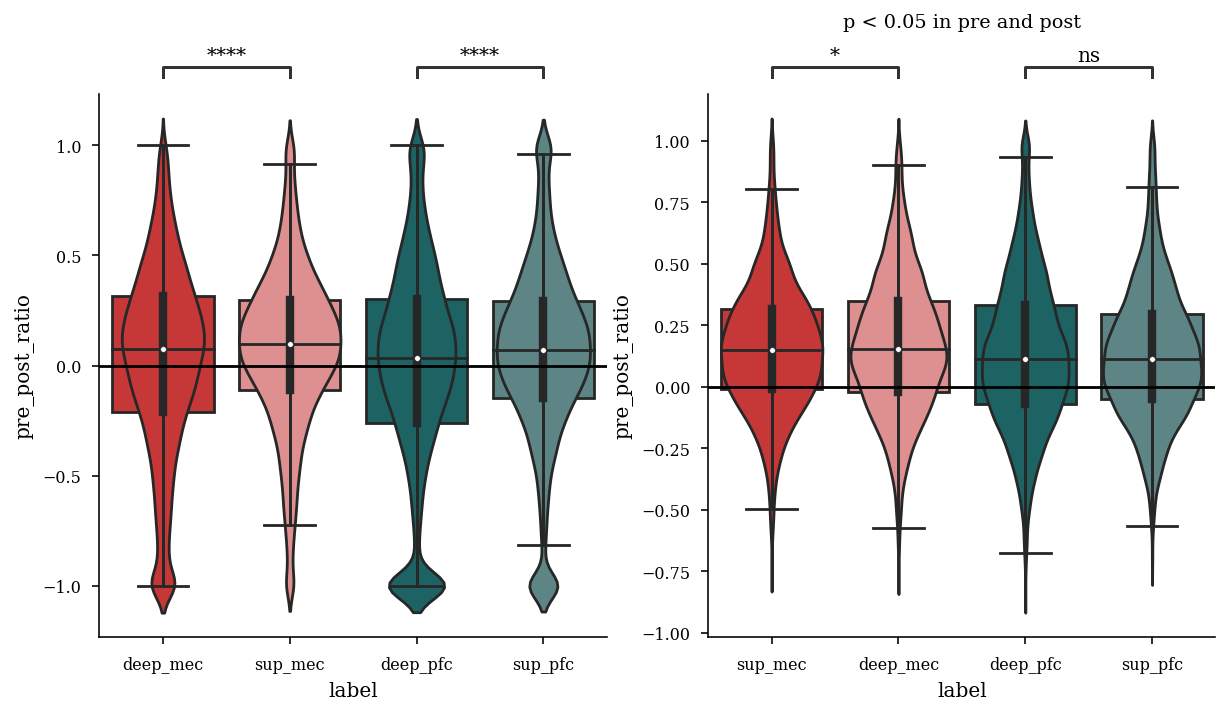

In [442]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.violinplot(
    x="label", y="pre_post_ratio", data=results_pivot, showfliers=False, ax=ax[0]
)
sns.boxplot(
    x="label", y="pre_post_ratio", data=results_pivot, showfliers=False, ax=ax[0]
)
ax[0].axhline(0, color="black")

box_pairs = [
    ("sup_mec", "deep_mec"),
    ("sup_pfc", "deep_pfc"),
]
annotator = Annotator(
    ax[0],
    box_pairs,
    data=results_pivot,
    x="label",
    y="pre_post_ratio",
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()

sns.violinplot(
    x="label",
    y="pre_post_ratio",
    data=results_pivot[results_pivot["pval_pre_post"]],
    showfliers=False,
    ax=ax[1],
)
sns.boxplot(
    x="label",
    y="pre_post_ratio",
    data=results_pivot[results_pivot["pval_pre_post"]],
    showfliers=False,
    ax=ax[1],
)
ax[1].set_title("p < 0.05 in pre and post",y=1.1)
ax[1].axhline(0, color="black")

box_pairs = [
    ("sup_mec", "deep_mec"),
    ("sup_pfc", "deep_pfc"),
]
annotator = Annotator(
    ax[1],
    box_pairs,
    data=results_pivot[results_pivot["pval_pre_post"]],
    x="label",
    y="pre_post_ratio",
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()

sns.despine()
plt.show()


In [346]:
results.describe()

,mutual_info,pval,reference_id,target_id,reference_uid,target_uid,conditional_entropy
count,278367.000000,278367.000000,556734.000000,556734.000000,556734.000000,556734.000000,278367.000000
mean,0.096097,0.516831,108.848786,130.150654,187.499035,225.443425,1.064532
std,0.145453,0.459952,74.146949,81.981350,130.538103,137.297610,0.745694
min,0.000000,0.001996,0.000000,0.000000,1.000000,1.000000,0.000000
25%,0.017269,0.001996,34.000000,62.000000,67.000000,117.000000,0.458473
50%,0.053002,0.606786,111.000000,117.000000,189.000000,218.000000,0.976397
75%,0.115145,1.000000,174.000000,197.000000,279.000000,307.000000,1.541524
max,2.550341,1.000000,255.000000,318.000000,743.000000,743.000000,4.988696


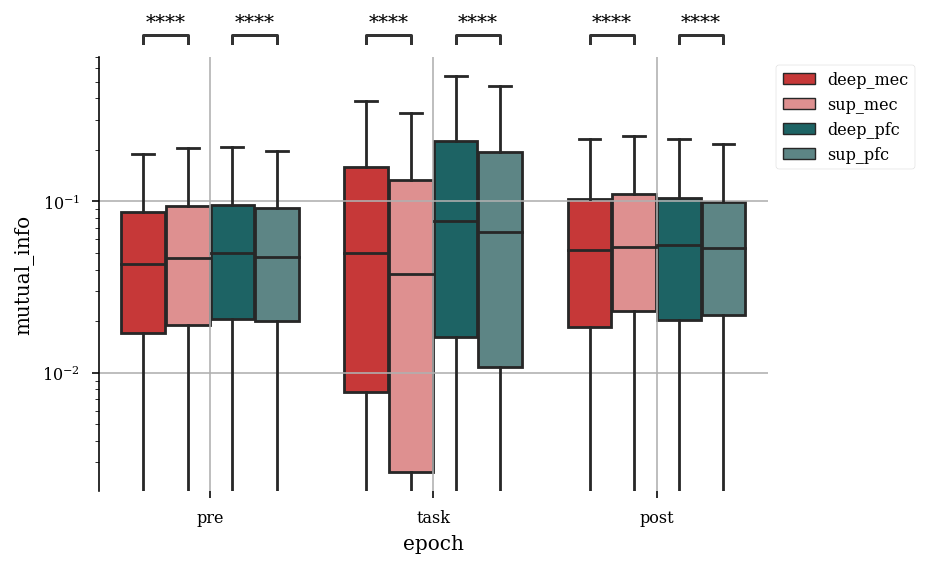

In [357]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))

sns.boxplot(
    x="epoch",
    hue="label",
    y="mutual_info",
    hue_order=group_colors.keys(),
    data=results,
    showfliers=False,
)
# sns.stripplot(
#     x="epoch",
#     hue="label",
#     y="mutual_info",
#     hue_order=group_colors.keys(),
#     data=results,
#     dodge=True,
#     size=2,
# )

plt.yscale("log")

plt.grid()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.despine(bottom=True)
# plt.gca().yaxis.set_minor_locator(AutoMinorLocator())

box_pairs = [
    (("pre", "deep_mec"), ("pre", "sup_mec")),
    (("pre", "deep_pfc"), ("pre", "sup_pfc")),
    (("task", "deep_mec"), ("task", "sup_mec")),
    (("task", "deep_pfc"), ("task", "sup_pfc")),
    (("post", "deep_mec"), ("post", "sup_mec")),
    (("post", "deep_pfc"), ("post", "sup_pfc")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="epoch",
    y="mutual_info",
    hue="label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()


<AxesSubplot:xlabel='epoch', ylabel='mutual_info'>

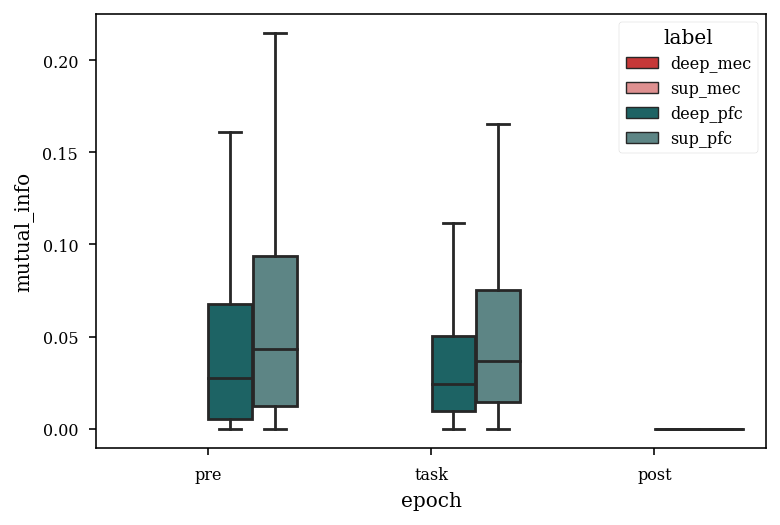

In [462]:
results[results.basepath == "Z:\Data\FujisawaS\EE\EE0705fm"]

sns.boxplot(
    x="epoch",
    hue="label",
    y="mutual_info",
    hue_order=group_colors.keys(),
    data=results[results.basepath == "Z:\Data\FujisawaS\EE\EE0705fm"],
    showfliers=False,
)

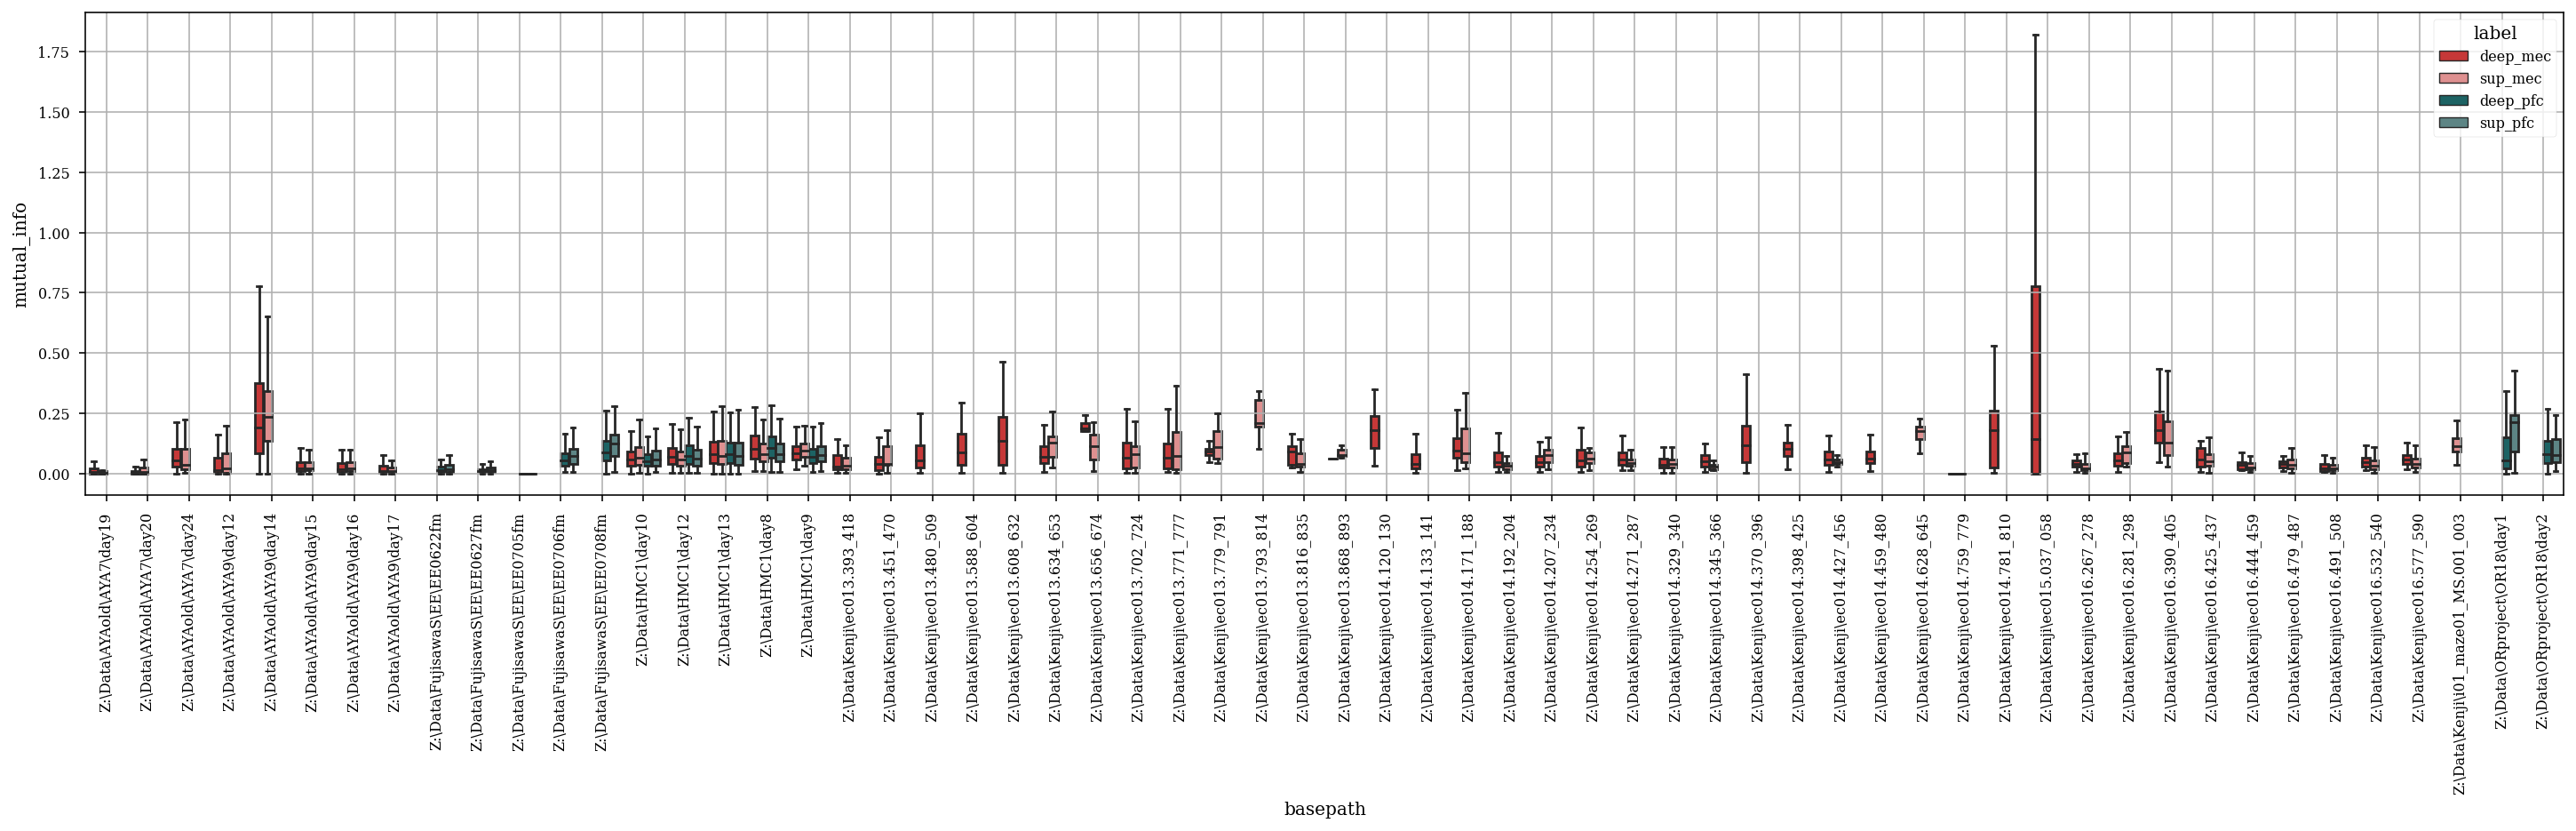

In [457]:
plt.figure(figsize=(25, 5))
sns.boxplot(
    x="basepath",
    hue="label",
    y="mutual_info",
    hue_order=group_colors.keys(),
    data=results[results.epoch == "post"],
    showfliers=False,
)
plt.xticks(rotation=90)
plt.grid()

<AxesSubplot:xlabel='epoch', ylabel='mutual_info'>

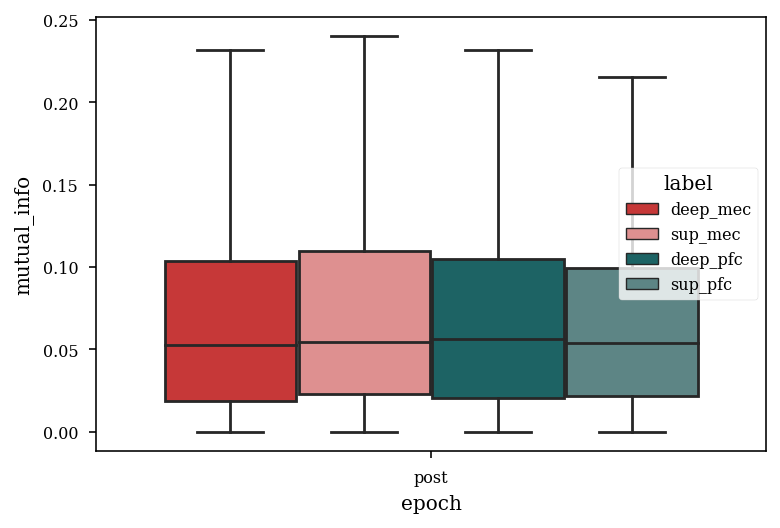

In [448]:
# results["mutual_info_trans"] = (results.mutual_info+.1)**-1.060606
sns.boxplot(
    x="epoch",
    hue="label",
    y="mutual_info",
    hue_order=group_colors.keys(),
    data=results[results.epoch == "post"],
    showfliers=False,
)
# sns.stripplot(
#     x="epoch",
#     hue="label",
#     y="mutual_info",
#     hue_order=group_colors.keys(),
#     data=results,
#     order=["pre","task","post"],
#     dodge=True,
#     color="k",
#     alpha=.1
# )
# plt.yscale("log")


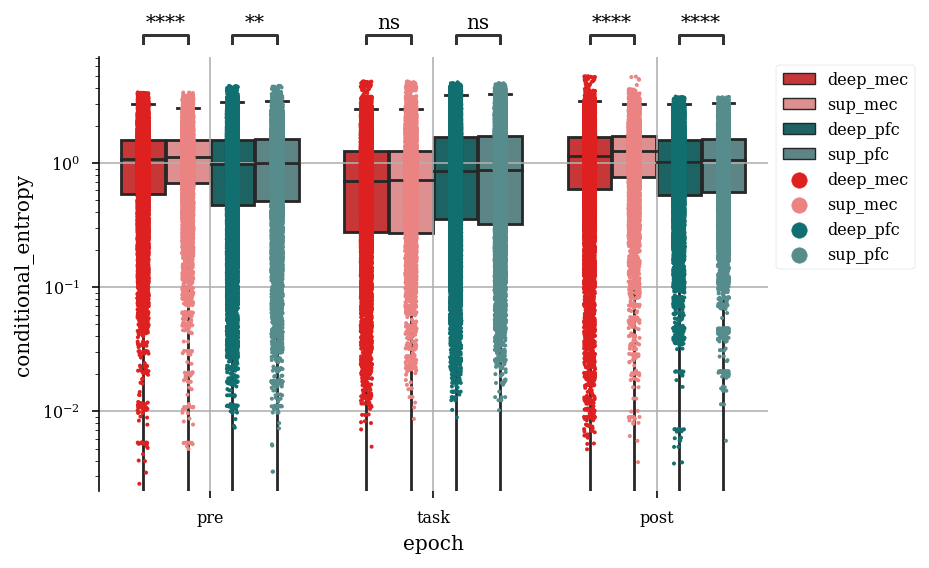

In [239]:
sns.boxplot(
    x="epoch",
    hue="label",
    y="conditional_entropy",
    hue_order=group_colors.keys(),
    data=results,
    showfliers=False,
)
sns.stripplot(
    x="epoch",
    hue="label",
    y="conditional_entropy",
    hue_order=group_colors.keys(),
    data=results,
    dodge=True,
    size=2,
)

plt.yscale("log")
plt.grid()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
sns.despine(bottom=True)

box_pairs = [
    (("pre", "deep_mec"), ("pre", "sup_mec")),
    (("pre", "deep_pfc"), ("pre", "sup_pfc")),
    (("task", "deep_mec"), ("task", "sup_mec")),
    (("task", "deep_pfc"), ("task", "sup_pfc")),
    (("post", "deep_mec"), ("post", "sup_mec")),
    (("post", "deep_pfc"), ("post", "sup_pfc")),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results,
    x="epoch",
    y="conditional_entropy",
    hue="label",
    hue_order=group_colors.keys(),
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
plt.show()

In [274]:
# add animal id to results
results["animal_id"] = results.basepath.map(dict([(basepath, loading.get_animal_id(basepath)) for basepath in results.basepath.unique()]))
results.animal_id.unique()

array(['AYA7', 'AYA9', 'EE', 'HMC1', 'ec013', 'ec014', 'Kenji', 'ec016',
       'i01_m', 'OR18'], dtype=object)

In [275]:
results.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\downstream_information_results.csv")

# Testing below

In [8]:
from pyinform import conditional_entropy,entropy_rate,mutual_info,transfer_entropy

# xs = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1]
# ys = [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1]
# conditional_entropy(xs,ys) 

In [5]:
basepath = r"Z:\Data\HMC1\day13"
st,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="PFC|CA1|MEC")

In [6]:
ripples_df = loading.load_ripples_events(basepath)
ripples = nel.EpochArray(np.array([ripples_df.start,ripples_df.stop]).T).expand(0.05,direction="start").expand(0.2,direction="stop")
# ripples.expand(0.05,direction="start")

ripple_mat = functions.get_participation(st.data,ripples.starts,ripples.stops,par_type="firing_rate")
ripple_mat.shape

(319, 7471)

In [52]:
import itertools


def pairwise_info(X):
    """
    Compute the pairwise mutual information between all pairs of variables in X.
    inputs:
        X: a numpy array of shape (n,d) where d is the number of samples and n is the number of variables
    outputs:
        a numpy array of shape (n,n) where the (i,j) entry is the mutual information between the ith and jth variables

    """
    x = np.arange(0, X.shape[0])
    pairs = np.array(list(itertools.combinations(x, 2)))
    mi = []
    ce = []
    for pair in pairs:
        mi.append(mutual_info(X[pair[0], :], X[pair[1], :]))
        ce.append(conditional_entropy(X[pair[0], :], X[pair[1], :]))
    return np.hstack(mi),np.hstack(ce), pairs

def pairwise_conditional_entropy(X):
    """
    Compute the pairwise mutual information between all pairs of variables in X.
    inputs:
        X: a numpy array of shape (n,d) where d is the number of samples and n is the number of variables
    outputs:
        a numpy array of shape (n,n) where the (i,j) entry is the mutual information between the ith and jth variables

    """
    x = np.arange(0, X.shape[0])
    pairs = np.array(list(itertools.product(x,repeat=2)))
    ce = []
    for pair in pairs:
        ce.append(conditional_entropy(X[pair[0], :], X[pair[1], :]))
    return np.hstack(ce), pairs

mi, ce, pairs_mi= pairwise_info(ripple_mat)
ce, pairs_ce = pairwise_conditional_entropy(ripple_mat)


In [103]:
def find_pairs(cm,pairs,pair_1,pair_2,layer):
    pairs_idx = (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains(pair_1) & cm.deepSuperficial.str.contains(layer))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains(pair_2))[0])
    ) | (
        np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains(pair_2))[0])
        & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains(pair_1) & cm.deepSuperficial.str.contains(layer))[0])
    )
    return pairs_idx
deep_pfc = find_pairs(cm,pairs_mi,"CA1","PFC","Deep")
deep_mec = find_pairs(cm,pairs_mi,"CA1","MEC","Deep")
sup_pfc = find_pairs(cm,pairs_mi,"CA1","PFC","Superficial")
sup_mec = find_pairs(cm,pairs_mi,"CA1","MEC","Superficial")

In [140]:


def make_df(ce,pairs,cm,y_label=None):
    deep_pfc = find_pairs(cm,pairs,"CA1","PFC","Deep")
    deep_mec = find_pairs(cm,pairs,"CA1","MEC","Deep")
    sup_pfc = find_pairs(cm,pairs,"CA1","PFC","Superficial")
    sup_mec = find_pairs(cm,pairs,"CA1","MEC","Superficial")

    df = pd.DataFrame()

    df[y_label] = np.hstack([ce[deep_pfc], ce[deep_mec], ce[sup_pfc], ce[sup_mec]])
    df["label"] = np.hstack(
        [
            ["deep_pfc"] * len(ce[deep_pfc]),
            ["deep_mec"] * len(ce[deep_mec]),
            ["sup_pfc"] * len(ce[sup_pfc]),
            ["sup_mec"] * len(ce[sup_mec]),
        ]
    )
    df["reference_id"] = np.hstack(
        [
            pairs[deep_pfc, 0],
            pairs[deep_mec, 0],
            pairs[sup_pfc, 0],
            pairs[sup_mec, 0],
        ]
    )

    df["target_id"] = np.hstack(
        [
            pairs[deep_pfc, 1],
            pairs[deep_mec, 1],
            pairs[sup_pfc, 1],
            pairs[sup_mec, 1],
        ]
    )

    df["reference"] = np.hstack(
        [
            cm.brainRegion.iloc[pairs[deep_pfc, 0]],
            cm.brainRegion.iloc[pairs[deep_mec, 0]],
            cm.brainRegion.iloc[pairs[sup_pfc, 0]],
            cm.brainRegion.iloc[pairs[sup_mec, 0]],
        ]
    )

    df["target"] = np.hstack(
        [
            cm.brainRegion.iloc[pairs[deep_pfc, 1]],
            cm.brainRegion.iloc[pairs[deep_mec, 1]],
            cm.brainRegion.iloc[pairs[sup_pfc, 1]],
            cm.brainRegion.iloc[pairs[sup_mec, 1]],
        ]
    )
    df["reference_uid"] = np.hstack(
        [
            cm.UID.iloc[pairs[deep_pfc, 0]],
            cm.UID.iloc[pairs[deep_mec, 0]],
            cm.UID.iloc[pairs[sup_pfc, 0]],
            cm.UID.iloc[pairs[sup_mec, 0]],
        ]
    )

    df["target_uid"] = np.hstack(
        [
            cm.UID.iloc[pairs[deep_pfc, 1]],
            cm.UID.iloc[pairs[deep_mec, 1]],
            cm.UID.iloc[pairs[sup_pfc, 1]],
            cm.UID.iloc[pairs[sup_mec, 1]],
        ]
    )
    return df


In [113]:
conditional_entropy_df = make_df(ce,pairs_ce,cm,"conditional_entropy")
conditional_entropy_df.loc[~conditional_entropy_df.reference.str.contains("CA1"),"conditional_entropy"] = np.nan
conditional_entropy_df.dropna(inplace=True)
conditional_entropy_df

,conditional_entropy,label,reference_id,target_id,reference,target,reference_uid,target_uid
11205,1.360668,deep_pfc,135,0,CA1so,PFC,272,1
11206,0.994142,deep_pfc,135,1,CA1so,PFC,272,2
11207,0.942368,deep_pfc,135,2,CA1so,PFC,272,3
11208,1.533153,deep_pfc,135,3,CA1so,PFC,272,4
11209,1.537234,deep_pfc,135,4,CA1so,PFC,272,6
...,...,...,...,...,...,...,...,...
45517,0.310773,sup_mec,246,314,CA1sr,MEC,420,540
45518,0.800484,sup_mec,246,315,CA1sr,MEC,420,541
45519,0.641952,sup_mec,246,316,CA1sr,MEC,420,542
45520,1.954237,sup_mec,246,317,CA1sr,MEC,420,546


In [114]:
mutual_info_df = make_df(mi,pairs_mi,cm,"mutual_info")

mutual_info_df

,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid
0,0.067176,deep_pfc,0,135,PFC,CA1so,1,272
1,0.078890,deep_pfc,0,136,PFC,CA1so,1,274
2,0.084916,deep_pfc,0,138,PFC,CA1so,1,279
3,0.043270,deep_pfc,0,139,PFC,CA1so,1,281
4,0.056667,deep_pfc,0,140,PFC,CA1so,1,283
...,...,...,...,...,...,...,...,...
23953,0.026522,sup_mec,246,314,CA1sr,MEC,420,540
23954,0.070829,sup_mec,246,315,CA1sr,MEC,420,541
23955,0.057868,sup_mec,246,316,CA1sr,MEC,420,542
23956,0.209924,sup_mec,246,317,CA1sr,MEC,420,546


In [115]:
test_df = pd.concat([mutual_info_df, conditional_entropy_df],ignore_index=True)
test_df

,mutual_info,label,reference_id,target_id,reference,target,reference_uid,target_uid,conditional_entropy
0,0.067176,deep_pfc,0,135,PFC,CA1so,1,272,NaN
1,0.078890,deep_pfc,0,136,PFC,CA1so,1,274,NaN
2,0.084916,deep_pfc,0,138,PFC,CA1so,1,279,NaN
3,0.043270,deep_pfc,0,139,PFC,CA1so,1,281,NaN
4,0.056667,deep_pfc,0,140,PFC,CA1so,1,283,NaN
...,...,...,...,...,...,...,...,...,...
47911,NaN,sup_mec,246,314,CA1sr,MEC,420,540,0.310773
47912,NaN,sup_mec,246,315,CA1sr,MEC,420,541,0.800484
47913,NaN,sup_mec,246,316,CA1sr,MEC,420,542,0.641952
47914,NaN,sup_mec,246,317,CA1sr,MEC,420,546,1.954237


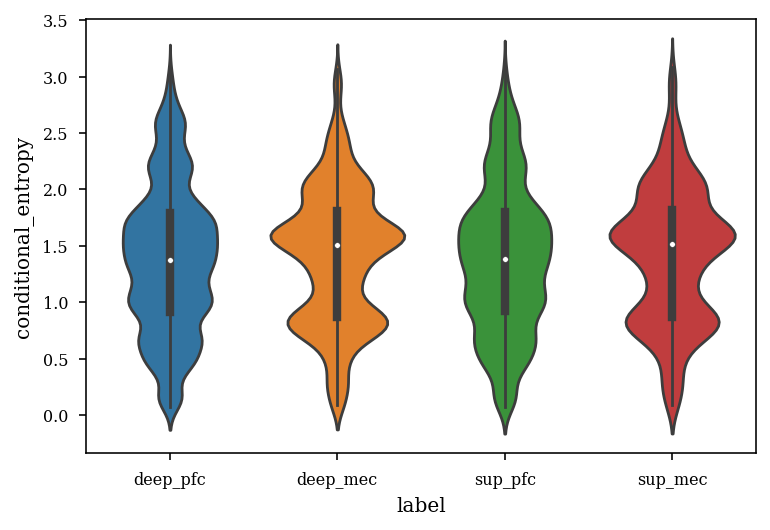

<AxesSubplot:xlabel='label', ylabel='mutual_info'>

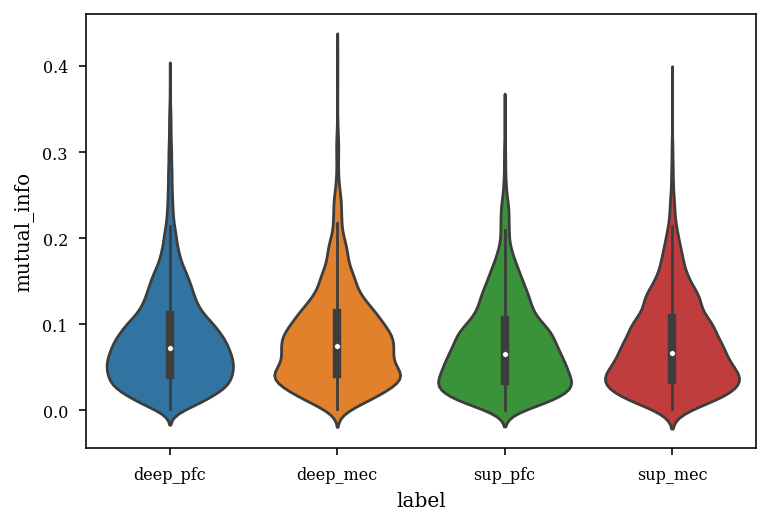

In [116]:
sns.violinplot(x="label", y="conditional_entropy", data=test_df)
plt.show()
sns.violinplot(x="label", y="mutual_info", data=test_df)


<AxesSubplot:xlabel='label', ylabel='conditional_entropy'>

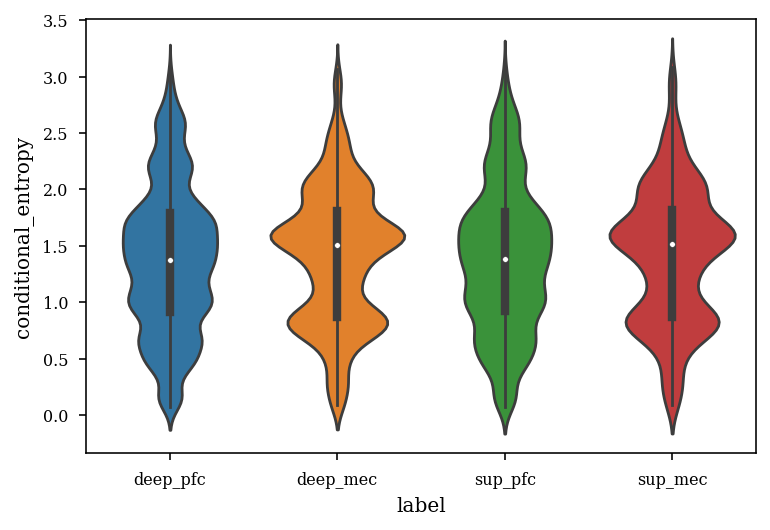

In [54]:
sns.violinplot(x="label", y="conditional_entropy", data=df)

In [38]:
deep_pfc = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("PFC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("PFC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
)

deep_mec = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("MEC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("MEC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"))[0])
)

sup_pfc = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("PFC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("PFC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
)

sup_mec = idx = (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("MEC"))[0])
) | (
    np.in1d(pairs[:, 0], np.where(cm.brainRegion.str.contains("MEC"))[0])
    & np.in1d(pairs[:, 1], np.where(cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"))[0])
)

In [12]:
df = pd.DataFrame()
df["mutual_info"] = np.hstack([mi[deep_pfc], mi[deep_mec], mi[sup_pfc], mi[sup_mec]])
df["conditional_entropy"] = np.hstack([ce[deep_pfc], ce[deep_mec], ce[sup_pfc], ce[sup_mec]])
df["label"] = np.hstack(
    [
        ["deep_pfc"] * len(mi[deep_pfc]),
        ["deep_mec"] * len(mi[deep_mec]),
        ["sup_pfc"] * len(mi[sup_pfc]),
        ["sup_mec"] * len(mi[sup_mec]),
    ]
)
df["reference"] = np.hstack(
    [
        cm.brainRegion.iloc[pairs[deep_pfc, 0]],
        cm.brainRegion.iloc[pairs[deep_mec, 0]],
        cm.brainRegion.iloc[pairs[sup_pfc, 0]],
        cm.brainRegion.iloc[pairs[sup_mec, 0]],
    ]
)

df["target"] = np.hstack(
    [
        cm.brainRegion.iloc[pairs[deep_pfc, 1]],
        cm.brainRegion.iloc[pairs[deep_mec, 1]],
        cm.brainRegion.iloc[pairs[sup_pfc, 1]],
        cm.brainRegion.iloc[pairs[sup_mec, 1]],
    ]
)

df["reference_uid"] = np.hstack(
    [
        cm.UID.iloc[pairs[deep_pfc, 0]],
        cm.UID.iloc[pairs[deep_mec, 0]],
        cm.UID.iloc[pairs[sup_pfc, 0]],
        cm.UID.iloc[pairs[sup_mec, 0]],
    ]
)

df["target_uid"] = np.hstack(
    [
        cm.UID.iloc[pairs[deep_pfc, 1]],
        cm.UID.iloc[pairs[deep_mec, 1]],
        cm.UID.iloc[pairs[sup_pfc, 1]],
        cm.UID.iloc[pairs[sup_mec, 1]],
    ]
)
df


,mutual_info,conditional_entropy,label,reference,target,reference_uid,target_uid
0,0.067176,1.429065,deep_pfc,PFC,CA1so,1,272
1,0.078890,1.717974,deep_pfc,PFC,CA1so,1,274
2,0.084916,1.647071,deep_pfc,PFC,CA1so,1,279
3,0.043270,1.159592,deep_pfc,PFC,CA1so,1,281
4,0.056667,1.454070,deep_pfc,PFC,CA1so,1,283
...,...,...,...,...,...,...,...
23953,0.026522,0.310773,sup_mec,CA1sr,MEC,420,540
23954,0.070829,0.800484,sup_mec,CA1sr,MEC,420,541
23955,0.057868,0.641952,sup_mec,CA1sr,MEC,420,542
23956,0.209924,1.954237,sup_mec,CA1sr,MEC,420,546


In [18]:
df.loc[~df.reference.str.contains("CA1"),"conditional_entropy"] = np.nan

<AxesSubplot:xlabel='mutual_info', ylabel='conditional_entropy'>

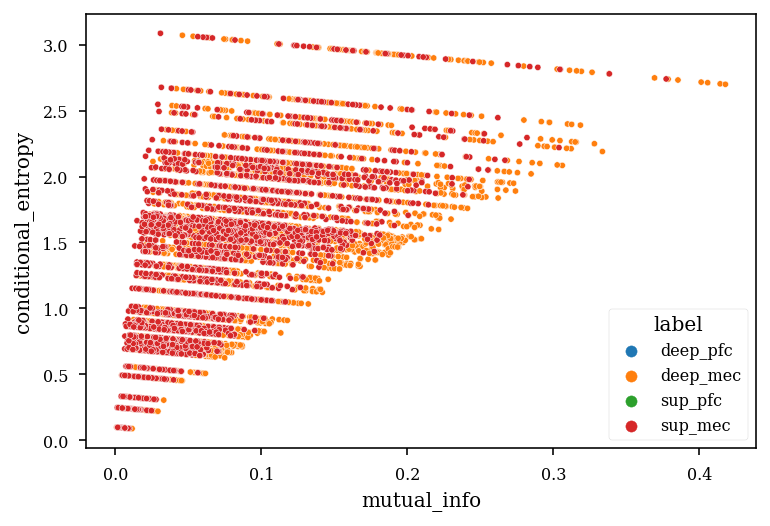

In [19]:
sns.scatterplot(x="mutual_info", y="conditional_entropy", hue="label", data=df,s=10)

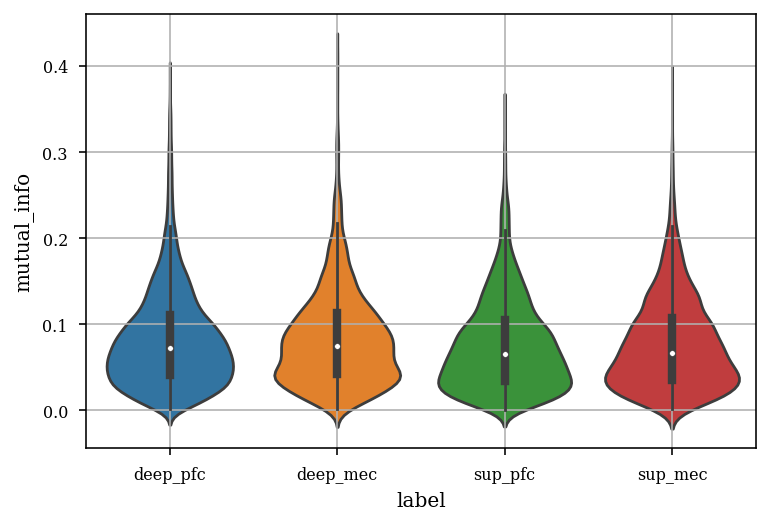

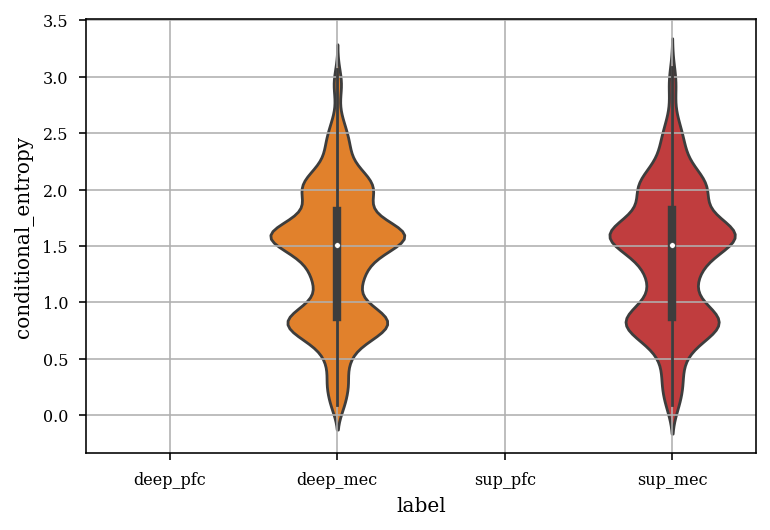

In [20]:
sns.violinplot(x="label", y="mutual_info", data=df)
# sns.stripplot(x="label", y="mi", data=df, color="black", size=1)
# plt.yscale("log")
plt.grid()
plt.show()

sns.violinplot(x="label", y="conditional_entropy", data=df)

plt.grid()
plt.show()